# Bioretention Blues Model

This workbook will walk through the use and application of the bioretention blues model presented in Rodgers et al. (in prep). The underlying code is contained in a few python modules, which are available from:
https://github.com/tfmrodge/SubsurfaceSinks

Briefly, the bioretention blues model is an activity-based "level V" multimedia mass-balance model of a stormwater bioretention cell. In this workbook, we will use the parameterization of the Kortright bioretention cell located near Toronto, Canada and the data from a spike and recovery test on that system. Please see Rodgers et al (in prep) for full details on the model development.

## Interactive Notebook Overview
### Layout and Data Structure
The notebook is laid out to first run the model, then display the built in fate figure. Other results and figures can be made by using Python packages such as matplotlib, referencing the results dataframe. The results dataframe is a pandas dataframe with a multi-index organized as `[chemical,time index,space index]` with all non-discretized compartments considered to be in the final space index (which have an "x" of 999). Pulling data uses a structure of:
`results.loc[(chemical,time_index,space_index),'column']`, where 'column' is a named output of interest (e.g. 'water'). If you want to leave one index undefined put slice(None) in that location e.g.:
`results.loc[(chemical,slice(None),space_index),'column']` would give the results for a specific chemical, in a specific column, at a specific location, across the entire time series. For more info see https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html

### Input/Parameter Files
The following files and parameter values can be changed by a user to parameterize the model. These files are all excel files with column and row names that are referenced by the model code and so care should be taken if you want to modify them.

numc - "numc" is a list of the compartments in the model as strings. For the BC Blues model, these compartments are: water (representing mobile subsurface water), subsoil (representing the bioretention soil media), rootbody (representing the root body), rootxylem (representing the root xylem), rootcyl (representing the root central cylinder), shoots (representing plant shoots), air (representing the lower atmosphere), pond (representing water in a transient ponding zone). Inputting fewer compartments will truncate the model to run with only the chosen compartments - use caution as e.g. only having root xylem and not the other root compartments may not give a consistent result. These names are referenced in the model software, so changing them may require changes to the code.<br>
<br>
locsumm - The locsumm file contains the dimensions of the system at the initial condition. The index matches numc, with the addition of sub-compartments within the soil compartment. A "topsoil" region is defined to represent e.g. mulch or added organic matter, allowing two sections of the bioretention cell to be defined. Additionally, a "drain" and "drain_pores" region are defined that are used in calculating the hydrology of the system. In the contmainant transport and fate model the topsoil and drain regions are included in the "subsoil" compartment, differentiated in depth. In the contaminant transport model the "drain" region is treated as a final single mixed finite volume consisting of soil and mobile water alone (no root compartments). Some volumes, such as the volume of the water compartment, will be updated according to model calculations as the model progresses. The columns of the locsumm file are the Area (cross-sectional, as seen from above in m²) of the compartment, the Depth (m) of the compartment, the density (kg/m³) of the compartment (compartment solids for mixed compartments), the temperature (°C), frnwat, the fraction of the compartment that is water (unitless), the porosity (unitless), FrnOC the fraction of organic carbon (unitless), FrnAir the fraction of the compartment that is air, the pH of the compartment, the conductivity of the compartment (uS), FrnPart the fraction of the compartment that is particles, PartDensity the density of particles in the compartment, Advection the external flow rate through the compartment (leave as 0 for air and water, which are calculated seperately), Discrete - 1 or 0 marks whether the comparment is discretized. <br>
<br>
chemsumm - the chemsumm file contains the physicochemical properties of the chemicals used in the model. Each row represents a different chemical, and these can be changed at-will. Note that running too many chemicals may give a memory error, depending on the amount of RAM on your machine. The columns of the chemsumm file are the chemical name, which is used as an index, the molar mas (g/mol), the water diffusion coefficient (m²/h),the air diffusion coefficient (m²/h), the air hydroxyl rate constant (cm³/molecule/s), the half life in water, soil and vegetation, log Kow, log Kaw, Log KocW, pKa, pKb, the chemical charge (enter 0 for neutral, -1 for an acid, 1 for a base), then the Abraham solvation parameters L, S, A, B and V for use in ppLFERS. The user can specify any partition coefficient that is used in the model (e.g. aerosol-air Kqa is calculated using a ppLFER) by adding a column to the sheet, or can remove a partition coefficient's column if they want that to be calculated using a ppLFER. The user just needs to make sure the column name matches what is written in the model - this requires going into the "SubsurfaceSinks" module in the "input_calcs" method. Compound identifiers (e.g. SMILES, CAS) can be added for convenience.<br>
<br>
params - this worksheet contains the parameters used in the model. The first column is the name of the parameters and the second column "val" is(are) the value(s) for that parameter. Parameter descriptions and references are provided in the Excel sheet, in the columns to the right of the "val" column.<br>
<br>
timeseries - The "timeseries" column contains any time-varying inputs to the model. The first "time" (h) column, should be floats. The columns are: Qin, inflow to the ponding zone (m³/h), Qout_meas, measured outflow from the system (used for comparison and graphing purposes, not as an input to the model)(m³/h), RainRate (m/h), WindSpeed (m/h), RH, relative humidity (%), Tair, temperature in the air (°C), Twater, temperature in the water (°C), Tsubsoil, temperature in the subsoil (°C), fvalveopen, the fraction that the valve exiting the underdrain is open where 0 indicates fully closed and 1 fully open, pHwater the pH of the water, pHsubsoil the pH of the subsoil immobile water, then there are several columns as chemname_Min, representing mass influx of a chemical in a unit time (g) and chemname_Coutmeas, representing the concentration exiting the system (units of concentration, g/m³ is default but this is not used as an input to the model so a user may express it as they wish). Each chemical in chemsumm must have a chemname_Min, or the model will return an error. 

In [1]:
#Load packages
#Standard packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
#This is the name of the python module containing the Bioretention Blues submodel.
from BioretentionBlues import BCBlues

In [4]:
#Load parameterization files
numc = ['water', 'subsoil','rootbody', 'rootxylem', 'rootcyl','shoots', 'air','pond']
#chemsumm = pd.read_excel('inputfiles/Kortright_ALL_CHEMSUMM.xlsx',index_col = 0)
locsumm = pd.read_excel('inputfiles/Pine8th/Pine8th_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/Pine8th/6PPDQ_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/Pine8th/params_Pine8th.xlsx',index_col = 0)
#The timeseries_test  is a smaller toy dataset for testing the model
timeseries = pd.read_excel('inputfiles/timeseries_test.xlsx')
Cin = 1000 #ng/L
for compound in chemsumm.index:
   minname = compound+'_Min'
   timeseries.loc[:,minname] = timeseries.Qin*Cin*1/60 
#The Pine8th configuration was used in Rodgers and Wang et al (2024) and Rodgers et al (2024)
#If you run this, comment out the above Cin changes
#timeseries = pd.read_excel('inputfiles/Pine8th/timeseries_Pine8th.xlsx')


#Instantiate the model. In this case we will ball the model object "bioretention_cell"
bc = BCBlues(locsumm,chemsumm,params,timeseries,numc)

In [5]:
#Run the model! This can take some time (~several hours) if the number of timesteps and chemicals is large.
#For the "timeseries_test" input, it only takes ~30 seconds
import pdb
#pdb.set_trace()
results = bc.run_BC(locsumm,chemsumm,timeseries,numc,params,pp=None)
results.head()

x        dx  time    dm  maskts  maskss  porositywater  \
6PPDQ 10 0  0.012778  0.025556   0.0  True   False    True           0.42   
         1  0.038333  0.025556   0.0  True   False    True           0.42   
         2  0.063889  0.025556   0.0  True   False    True           0.42   
         3  0.089444  0.025556   0.0  True   False    True           0.42   
         4  0.115000  0.025556   0.0  True   False    True           0.42   

              Awater  Vsubsoil        V2  ...  M6_t1  a7_t1  M7_t1  a8_t1  \
6PPDQ 10 0  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
         1  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
         2  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
         3  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   
         4  1.788351  0.511409  0.511409  ...    0.0    0.0    0.0    0.0   

            M8_t1  Mqin  Min_p  Mover_p  M_xf  M_n  
6PPDQ 10 0    0.0   0.0    0.0      NaN   0.0  0.0  
         1    0.0   NaN    NaN      NaN   0.0  0.0  
         2    0.0   NaN    NaN      NaN   0.0  0.0  
         3    0.0   NaN    NaN      NaN   0.0  0.0  
         4    0.0   NaN    NaN      NaN   0.0  0.0  

[5 rows x 475 columns]

## Working with & displaying the model results
Now the results from the model are stored in the "results" dataframe. We have a number of methods that will 
further process this data:
mass_flux(self,res_time,numc):
        This method calculates mass fluxes (mol/h) between compartments and
        out of the overall system. Calculations are done at the same discretization 
        level as the system, to get the overall mass fluxes for a compartment use 
        `mass_flux.loc[:,'Variable'].groupby(level=[0,1]).sum()`
        
mass_balance(self,res_time,numc,mass_flux = None,normalized = False):
        This method calculates a mass balance and the mass transfers (g) between compartments 
        on a whole-compartment basis. Use "normalized" to define if the mass balance is normalized to the total
        mass that has entered the system.
        
mass_balance_cumulative(self,numc,res_time=None,mass_flux = None,mass_balance = None,normalized=False):
        This method calculates cumulative mass transfers between compartments 
        on a whole-compartment (non spatially discretized) basis. 
        
conc_out(self,numc,timeseries,chemsumm,res_time,mass_flux=None):
        This method calculates modeled concentrations (g/m³) at the outlet for all chemicals present.
        
concentrations(self,numc,res_time):
        This method calculates modeled concentrations within the system.
         
mass_distribution(self,numc,res_time,timeseries,chemsumm,normalized = 'compartment'):
        This method calculates modeled mass distributions for the different compartments.
        
BC_fig(self,numc,mass_balance,time=None,compound=None,figname='BC_Model_Figure.tif',dpi=100,fontsize=8,figheight=6,dM_locs=None,M_locs=None):
            Show modeled fluxes and mass distributions on a bioretention cell figure. 
            The "dM_locs" and "M_locs" tell the figure where to display, and the image is called by figname. 
            
You can also save data by pickling it through pandas. 

In [6]:
#For the rest of this walk-through, we will use the outputs from Rodgers and Wang et al. 2023. So, lets load those:
#First - the .pkl file is too large to share on the github. Download it here: https://www.dropbox.com/scl/fi/kaa72rc0zbpdtym1ypen3/Pine8spiketest_20240807.pkl?rlkey=bzuygumjudb6hywxf69q079a3&st=0na8wkws&dl=0
#and add it to the "pickles" folder in this repository.
#Get the working directory - can save somewhere else, just change the directory
fpath = os.getcwd()
res = pd.read_pickle(fpath+'/pickles/Pine8spiketest_20240807.pkl')
#res = pd.read_pickle(fpath+'/pickles/outputtest.pkl')
#res.head()

In [7]:
#Great! Now lets see what the system looks like using built-in model figure. 
#Run our data processing methods (can take some time for a big file)
#Re-instantiate the model if needed with the appropriate input files
timeseries = pd.read_excel('inputfiles/timeseries_tracertest_Kortright_extended.xlsx')
bc = BCBlues(locsumm,chemsumm,params,timeseries,numc)
mbal = bc.mass_balance(res,numc)
mbal_cum = bc.mass_balance_cumulative(numc, mass_balance = mbal,normalized=True)

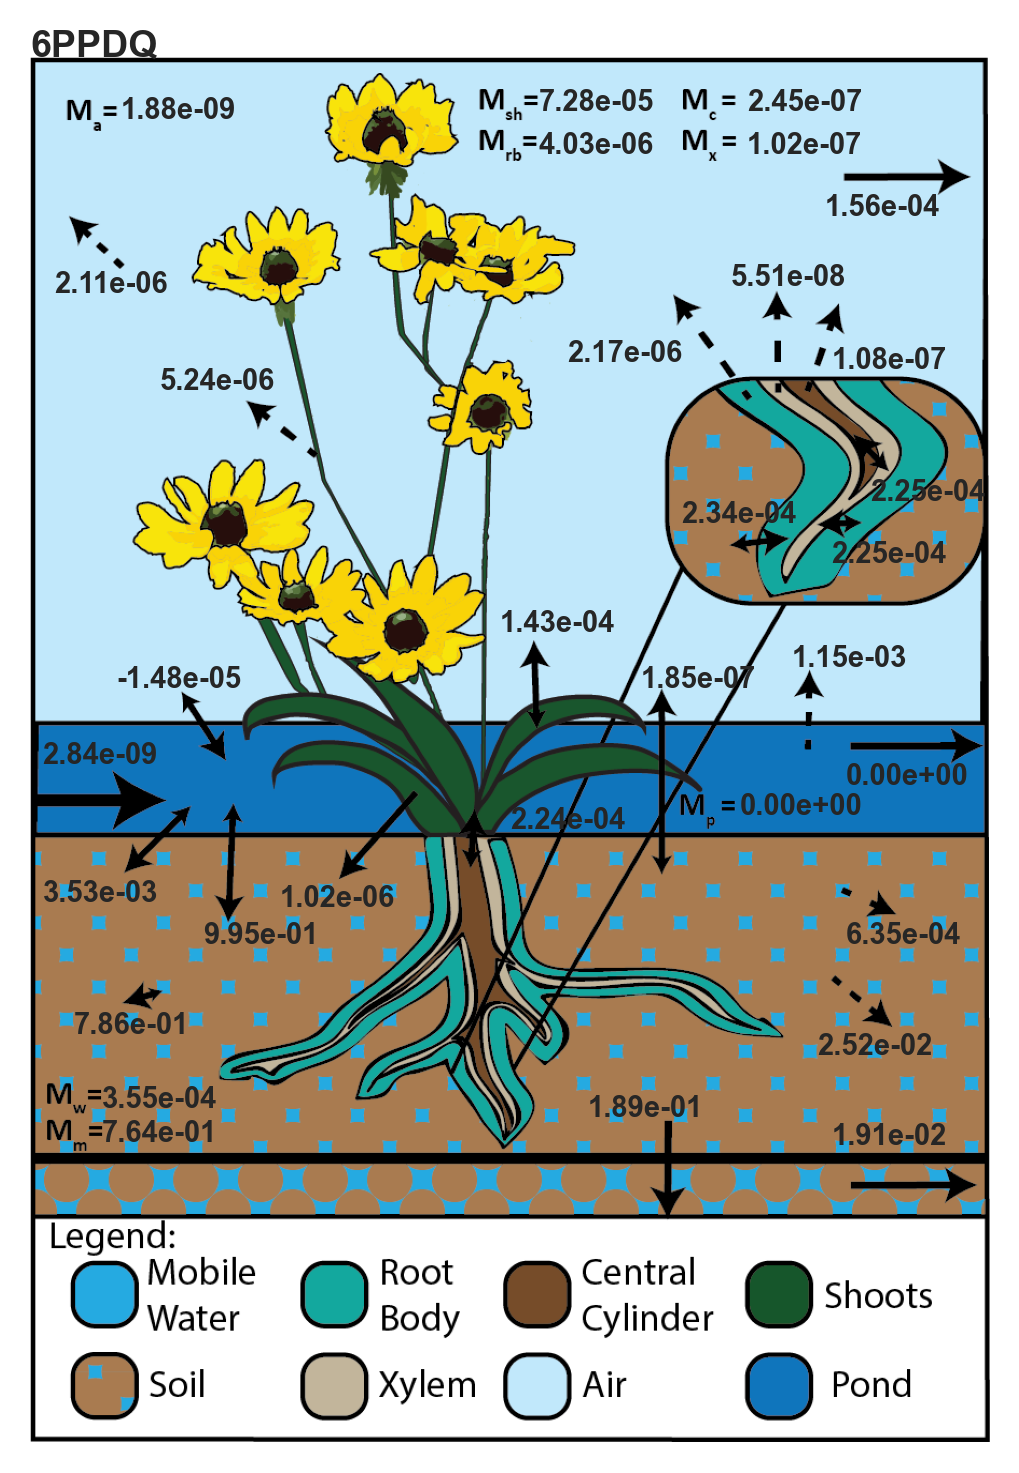

In [9]:
#Plot the figure. Choose the compound and the time to display (in hours).
compound = '6PPDQ'#use same name as in chemsumm
#Set time (hrs), any time after end gives the end.
time = 1000
fig,ax = bc.BC_fig(numc,mass_balance=mbal_cum,time = time,compound=compound,figheight=6,fontsize=7,dpi=300)
#Save the figure if you like. I save in pdf then edit in illustrator.
#fig.savefig('Figures/OutputModelFig.pdf', format='pdf',bbox_inches= 'tight')  

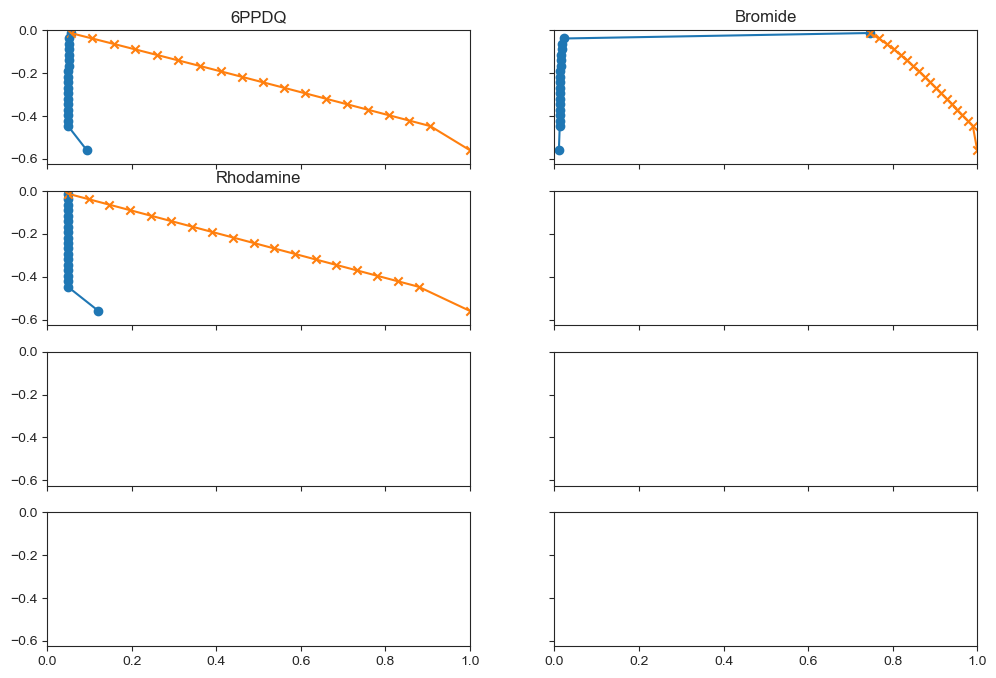

In [10]:
#Other figures can be made using standard packages. For instance, here are depth profiles of the concentration in
#the soil through the cell, made using seaborn and matplotlib
#Now we will define where we want to plot.
t = res.index.levels[1][-1] #End of time series. Need to define a time index, not a time, for this figure. 
#Call the mass distribution method. Calling this takes time, so comment out if  you just want to change times.
mdist = bc.mass_distribution(numc,res,timeseries,chemsumm)
sns.set_style("ticks")
#fig,axs = plt.subplots(10,2,sharex='all', sharey='all',figsize=(12,6))
fig,axs = plt.subplots(4,2,sharex='all', sharey='all',figsize=(12,8))
rowind,colind = 0,0
pltcompartment = 'M' +'subsoil'
for chem in mdist.index.levels[0]:
    #We will plot the non-cumulative and the cumulative together
    #Non-cumulative
    axs[rowind,colind].plot(mdist.loc[(chem,t,res.dm),pltcompartment]
                            ,-1*mdist.loc[(chem,t,res.dm),'x'])
    axs[rowind,colind].scatter(mdist.loc[(chem,t,res.dm),pltcompartment]
                            ,-1*mdist.loc[(chem,t,res.dm),'x'])
    #Cumulative
    #Line
    axs[rowind,colind].plot(mdist.loc[(chem,t,res.dm),pltcompartment].cumsum()
                            ,-1*mdist.loc[(chem,t,res.dm),'x'])
    axs[rowind,colind].scatter(mdist.loc[(chem,t,res.dm),pltcompartment].cumsum()
                            ,-1*mdist.loc[(chem,t,res.dm),'x'],marker = 'x')
    #Title
    axs[rowind,colind].set_title(str(chem))
    #Go through plot indices
    if colind == 1:
        colind =0
        rowind +=1
    else:
        colind +=1
axs[0,0].set(xlim=(0, 1))
axs[0,0].set(ylim=(-0.625, 0));

#fig.savefig('Figures/subsoil_mdist.pdf', format='pdf',bbox_inches= 'tight')   
#Orange x represents the cumulative mass distribution (going down), blue the mass at each finite volume.

## Model Without Vegetation
Running the model without vegetation decreases the memory and time requirements to run the model and the number of parameters that need to be defined. In Rodgers et al (2022) we found that direct uptake by plays was unimportant to the overall mass balance of the system, so this will not overly impact model results. All that needs to be done is to remove the 4 plant compartments from numc, and the model will run without them.

In [3]:
#Load parameterization files
numc = ['water', 'subsoil', 'air', 'pond'] #Remove ['rootbody','rootxylem','rootcyl','shoots']
locsumm = pd.read_excel('inputfiles/Kortright_BC.xlsx',index_col = 0)
chemsumm = pd.read_excel('inputfiles/Kortright_ALL_CHEMSUMM.xlsx',index_col = 0)
params = pd.read_excel('inputfiles/params_BC.xlsx',index_col = 0)
params.loc['numc_disc','val'] = 2
#The tracertest_Kortright_extended file was used in Rodgers et al. (2021), _test is a smaller toy dataset for 
#testing the model
#timeseries = pd.read_excel('timeseries_tracertest_Kortright_extended.xlsx')
timeseries = pd.read_excel('inputfiles/timeseries_test.xlsx')
#Instantiate the model. In this case we will ball the model object "bioretention_cell"
bc = BCBlues(locsumm,chemsumm,params,timeseries,numc)

In [4]:
#Run the model! This can take some time (several hours) if the number of timesteps and chemicals is large.
#For the "timeseries_test" set, it only takes a few seconds
results = bc.run_BC(locsumm,chemsumm,timeseries,numc,params,pp=None)
results.head()

D:\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Users\Tim Rodgers\Documents\GitHub\SubsurfaceSinks\Subsurface_Sinks.py:877: RuntimeWarning: invalid value encountered in true_divide
  /np.array(res.loc[(slice(None),(t),slice(None)),V_val])/np.array(res.loc[(slice(None),(t),slice(None)),Z_val])
D:\Users\Tim Rodgers\Documents\GitHub\SubsurfaceSinks\Subsurface_Sinks.py:882: RuntimeWarning: invalid value encountered in true_divide
  /np.array(res.loc[(slice(None),(t),slice(None)),Z_val])


x     dx  time    dm  maskts  maskss  porositywater  \
Benzotriazole 10 0  0.0125  0.025   0.0  True    True   False           0.50   
                 1  0.0375  0.025   0.0  True    True   False           0.50   
                 2  0.0625  0.025   0.0  True    True   False           0.50   
                 3  0.0875  0.025   0.0  True   False    True           0.42   
                 4  0.1125  0.025   0.0  True   False    True           0.42   

                      Awater  Vsubsoil        V2  ...  a2_t1  M2_t1  a3_t1  \
Benzotriazole 10 0  3.221902  0.152924  0.152924  ...   -0.0   -0.0    0.0   
                 1  3.221902  0.152924  0.152924  ...   -0.0   -0.0    0.0   
                 2  3.221902  0.152924  0.152924  ...   -0.0   -0.0    0.0   
                 3  2.706398  0.165811  0.165811  ...   -0.0   -0.0    0.0   
                 4  2.706398  0.165811  0.165811  ...   -0.0   -0.0    0.0   

                    M3_t1  a4_t1  M4_t1  Mqin  Min_p  M_xf  M_n  
Benzotriazole 10 0    0.0    0.0    0.0   0.0    0.0   0.0  0.0  
                 1    0.0    0.0    0.0   NaN    NaN   0.0  0.0  
                 2    0.0    0.0    0.0   NaN    NaN   0.0  0.0  
                 3    0.0    0.0    0.0   NaN    NaN   0.0  0.0  
                 4    0.0    0.0    0.0   NaN    NaN   0.0  0.0  

[5 rows x 235 columns]